In [ ]:
import os
import os.path
import sys
import h5py
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, BatchNormalization, Activation, Add, add
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Reshape, Multiply, Dropout, Input

from sklearn.model_selection import train_test_split

import json

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# ASCAD data loading

In [ ]:
ascad_database = "/content/drive/MyDrive/ASCAD_databases/ASCAD.h5"
RANDOM_STATE = 42
VAL_SIZE = 0.1

In [ ]:
def check_file_exists(file_path):
	file_path = os.path.normpath(file_path)
	if os.path.exists(file_path) == False:
		print("Error: provided file path '%s' does not exist!" % file_path)
		sys.exit(-1)
	return

In [ ]:
def load_ascad(ascad_database_file, load_metadata=False):
	check_file_exists(ascad_database_file)
	# Open the ASCAD database HDF5 for reading
	try:
		in_file	 = h5py.File(ascad_database_file, "r")
	except:
		print("Error: can't open HDF5 file '%s' for reading (it might be malformed) ..." % ascad_database_file)
		sys.exit(-1)
	# Load profiling traces
	X_profiling = np.array(in_file['Profiling_traces/traces'], dtype=np.int8)
	# Load profiling labels
	Y_profiling = np.array(in_file['Profiling_traces/labels'])
	# Load attacking traces
	X_attack = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
	# Load attacking labels
	Y_attack = np.array(in_file['Attack_traces/labels'])
	if load_metadata == False:
		return (X_profiling, Y_profiling), (X_attack, Y_attack)
	else:
		return (X_profiling, Y_profiling), (X_attack, Y_attack), (in_file['Profiling_traces/metadata'], in_file['Attack_traces/metadata'])

In [ ]:
def create_tf_dataset(X, y, batch_size=64, shuffle=True):
  ds = tf.data.Dataset.from_tensor_slices((X, y))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(X))
  ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
# Tuning
# from sklearn.model_selection import train_test_split

# (X_profiling, Y_profiling), (X_attack, Y_attack), (Profiling_meta, Attack_meta) = load_ascad(ascad_database, load_metadata=True)

# X_train, X_val, Y_train, Y_val = train_test_split(
#     X_profiling, Y_profiling, test_size=VAL_SIZE, random_state=RANDOM_STATE
# )

# # Get val indexes
# all_idxs = np.arange(len(X_profiling))
# train_idx, val_idx = train_test_split(all_idxs, test_size=VAL_SIZE, random_state=RANDOM_STATE)

# Y_train_cat = to_categorical(Y_train, num_classes=256)
# Y_val_cat = to_categorical(Y_val, num_classes=256)

In [ ]:
def get_tuning_dataset(val_size, random_state, load_metadata=False):
  if load_metadata:
    (X_profiling, Y_profiling), (X_attack, Y_attack), (Profiling_meta, Attack_meta) = load_ascad(ascad_database, load_metadata=True)
  else:
    (X_profiling, Y_profiling), (X_attack, Y_attack) = load_ascad(ascad_database)

  # Get val indexes
  all_idxs = np.arange(len(X_profiling))
  train_idx, val_idx = train_test_split(all_idxs, test_size=val_size, random_state=random_state)

  X_train = np.array(X_profiling)[train_idx]
  X_val = np.array(X_profiling)[val_idx]
  Y_train = np.array(Y_profiling)[train_idx]
  Y_val = np.array(Y_profiling)[val_idx]

  meta_train = np.array(Profiling_meta)[train_idx]
  meta_val = np.array(Profiling_meta)[val_idx]

  Y_train_cat = to_categorical(Y_train, num_classes=256)
  Y_val_cat = to_categorical(Y_val, num_classes=256)

  ds_train = create_tf_dataset(X_train, Y_train_cat)
  ds_val = create_tf_dataset(X_val, Y_val_cat, shuffle=False)

  if load_metadata:
    return ds_train, ds_val, (meta_train, meta_val)
  else:
    return ds_train, ds_val

In [ ]:
ds_train, ds_val, (meta_train, meta_val) = get_tuning_dataset(VAL_SIZE, RANDOM_STATE, load_metadata=True)

In [ ]:
# Full training
# from sklearn.model_selection import train_test_split

# (X_profiling, Y_profiling), (X_attack, Y_attack) = load_ascad(ascad_database)

# X_train_full = X_profiling
# Y_train_cat = to_categorical(Y_profiling, num_classes=256)

In [ ]:
def get_training_dataset():
  (X_profiling, Y_profiling), (_, _) = load_ascad(ascad_database)

  X_train_full = X_profiling
  Y_train_cat = to_categorical(Y_profiling, num_classes=256)

  ds_train = create_tf_dataset(X_train_full, Y_train_cat)

  return ds_train

In [ ]:
ds_train_full = get_training_dataset()

In [ ]:
# print(X_train_full.shape)
# print(Y_train_cat.shape)

(50000, 700)
(50000, 256)


In [ ]:
# Tuning
# ds_train = create_tf_dataset(X_train, Y_train_cat)
# ds_val = create_tf_dataset(X_val, Y_val_cat, shuffle=False)

In [ ]:
# Full train
# ds_train = create_tf_dataset(X_train_full, Y_train_cat)

# Squeeze Excitation block

Apply SE blocks to VGG (cnn best from ASCAD paper)

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Reshape, Multiply, Dropout, Input

def se_block(input_tensor, ratio=16):
  channels = input_tensor.shape[-1]
  se = GlobalAveragePooling1D()(input_tensor)
  se = Dense(channels // ratio, activation='relu')(se)
  se = Dense(channels, activation='sigmoid')(se)
  se = Reshape((1, channels))(se)
  return Multiply()([input_tensor, se])

In [ ]:
def cnn_squeeze_excite(filters, se_ratio, dropout_rate, classes=256,input_dim=700, batch_normalize=False):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(filters[0], 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	if batch_normalize:
		x = BatchNormalization()(x)
	# Block 2
	x = Conv1D(filters[1], 11, activation='relu', padding='same', name='block2_conv1')(x)
	if batch_normalize:
		x = BatchNormalization()(x)
	# Squeeze excitation block 1
	x = se_block(x, ratio=se_ratio)
	x = MaxPooling1D(2)(x)

	# Block 3
	x = Conv1D(filters[2], 11, activation='relu', padding='same', name='block3_conv1')(x)
	if batch_normalize:
		x = BatchNormalization()(x)
	# Block 4
	x = Conv1D(filters[3], 11, activation='relu', padding='same', name='block4_conv1')(x)
	if batch_normalize:
		x = BatchNormalization()(x)
  # Block 5
	x = Conv1D(filters[4], 11, activation='relu', padding='same', name='block5_conv1')(x)
	if batch_normalize:
		x = BatchNormalization()(x)
 	# Squeeze excitation block 1
	x = se_block(x, ratio=se_ratio)
	x = MaxPooling1D(2)(x)

	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dropout(dropout_rate)(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	x = Dropout(dropout_rate)(x)
	x = Dense(classes, activation='softmax', name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_squeeze_excitation')

	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model

## SE_VGG Hyperparameter tuning

Setup Keras tuning prerequisites

In [ ]:
!pip install keras-tuner --upgrade
import keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.1 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
import tensorflow.keras.backend as K
from tensorflow.keras.models import clone_model

class CleanMemoryTuner(kt.RandomSearch):
  """! Keras tuner wrapper to cleanup memory after each run.  """
  def run_trial(self, trial, *args, **kwargs):
    K.clear_session()
    return super().run_trial(trial, *args, **kwargs)

In [ ]:
def vgg_se_builder(hp):
  """! Hypermodel function - model builder for tuner
  """
  base_filters = hp.Choice("filter_scale", [1.0, 1.5, 2.0])
  filters = [int(f * base_filters) for f in [64, 128, 256, 512, 512]]
  dropout = hp.Float('dropout', 0.0, 0.6, step=0.3)
  se_ratio = hp.Choice('se_ratio', [8, 16, 32])

  model = cnn_squeeze_excite(filters=filters, dropout_rate=dropout, se_ratio=se_ratio)

  learning_rate = hp.Choice("learning_rate", [1e-5, 5e-5, 1e-4, 5e-4])
  optimizer = RMSprop(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

  return model

In [ ]:
tuner = CleanMemoryTuner(
    hypermodel=vgg_se_builder,
    objective="val_loss",
    max_trials=15,
    executions_per_trial=1,
    directory="/content/drive/MyDrive/attention_cnn_tuner",
    project_name="vgg_se_ascad"
)

In [ ]:
# No batch norm

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Setup callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/vgg_se_trial.keras", save_best_only=True)

# Run hyperparameter random search
tuner.search(ds_train, validation_data=ds_val, callbacks=[early_stop, checkpoint], epochs=75, batch_size=64)

In [ ]:
# Save best model - no batch norm

best_model_vgg_se = tuner.get_best_models(1)[0]
best_model_vgg_se.save("/content/drive/MyDrive/attention_cnn_tuner/vgg_se_best.keras")
# best_model_vgg_se.save_weights("/content/drive/MyDrive/vgg_se_best_weights.h5")

In [ ]:
import json
# Save best hyperparameters in a json file

best_hps = tuner.get_best_hyperparameters(1)[0]
with open("/content/drive/MyDrive/vgg_se_best_hps.json", "w") as f:
    json.dump(best_hps.values, f)

In [ ]:
import json
# Since the save from the tuner got lost - reload and retrain with best hps
with open("/content/drive/MyDrive/vgg_se_best_hps.json", "r") as f:
  hp_vals = json.load(f)

In [ ]:
hp_vals

{'filter_scale': 2.0, 'dropout': 0.1, 'se_ratio': 16, 'learning_rate': 5e-05}

In [ ]:
filter_scale = hp_vals['filter_scale']
filters = [int(f * filter_scale) for f in [64, 128, 256, 512, 512]]

dropout = hp_vals['dropout']
se_ratio = hp_vals['se_ratio']

learning_rate = hp_vals['learning_rate']

optimizer = RMSprop(learning_rate=learning_rate)
best_model_vgg_se = cnn_squeeze_excite(filters=filters, dropout_rate=dropout, se_ratio=se_ratio, optimizer=optimizer)
best_model_vgg_se.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

best_model_vgg_se.summary()

Model: "cnn_squeeze_excitation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 700, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 700, 128)  │      1,536 │ input_layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 700, 256)  │    360,704 │ block1_conv1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ block2_conv1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      4,112 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │      4,352 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 700, 256)  │          0 │ block2_conv1[0][… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 350, 256)  │          0 │ multiply[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 350, 512)  │  1,442,304 │ max_pooling1d[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 350, 1024) │  5,768,192 │ block3_conv1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 350, 1024) │ 11,535,360 │ block4_conv1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ block5_conv1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     65,600 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1024)      │     66,560 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1024)   │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 350, 1024) │          0 │ block5_conv1[0][… │
│ (Multiply)          │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 175, 1024) │          0 │ multiply_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 179200)    │          0 │ max_pooling1d_1[

 Total params: 771,086,160 (2.87 GB)

 Trainable params: 771,086,160 (2.87 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_full = ModelCheckpoint("/content/drive/MyDrive/vgg_se_recovery_chckpnt.keras", monitor='accuracy', save_best_only=True)

best_model_vgg_se.fit(ds_train, validation_data=ds_val, epochs=75, batch_size=64, callbacks=[checkpoint_full])

best_model_vgg_se.save("/content/drive/MyDrive/vgg_se_best_recovery.keras")

Epoch 1/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 268s 335ms/step - accuracy: 0.0040 - loss: 5.5486 - val_accuracy: 0.0042 - val_loss: 5.5451
Epoch 2/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 215s 306ms/step - accuracy: 0.0043 - loss: 5.5445 - val_accuracy: 0.0044 - val_loss: 5.5450
Epoch 3/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 180s 255ms/step - accuracy: 0.0036 - loss: 5.5442 - val_accuracy: 0.0044 - val_loss: 5.5449
Epoch 4/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 213s 302ms/step - accuracy: 0.0047 - loss: 5.5437 - val_accuracy: 0.0036 - val_loss: 5.5450
Epoch 5/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 180s 255ms/step - accuracy: 0.0042 - loss: 5.5436 - val_accuracy: 0.0044 - val_loss: 5.5448
Epoch 6/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 233s 331ms/step - accuracy: 0.0045 - loss: 5.5435 - val_accuracy: 0.0044 - val_loss: 5.5446
Epoch 7/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 229s 326ms/step - accuracy: 0.0051 - loss: 5.5434 - val_accuracy: 0.0044 - val_loss: 5.5451
Epoch 8/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 180s 255ms/step - accuracy: 0.0041 -

In [ ]:
best_model_vgg_se = tf.keras.models.load_model("/content/drive/MyDrive/vgg_se_recovery_chckpnt.keras")

In [ ]:
checkpoint_full = ModelCheckpoint("/content/drive/MyDrive/vgg_se_recovery_chckpnt.keras", monitor='accuracy', save_best_only=True)

best_model_vgg_se.fit(ds_train, validation_data=ds_val, epochs=75, batch_size=64, callbacks=[checkpoint_full])

best_model_vgg_se.save("/content/drive/MyDrive/vgg_se_best_recovery.keras")

Epoch 1/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 259s 327ms/step - accuracy: 0.0044 - loss: 5.5430 - val_accuracy: 0.0044 - val_loss: 5.5448
Epoch 2/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 178s 253ms/step - accuracy: 0.0048 - loss: 5.5431 - val_accuracy: 0.0044 - val_loss: 5.5450
Epoch 3/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 178s 253ms/step - accuracy: 0.0049 - loss: 5.5435 - val_accuracy: 0.0044 - val_loss: 5.5453
Epoch 4/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 178s 253ms/step - accuracy: 0.0046 - loss: 5.5429 - val_accuracy: 0.0044 - val_loss: 5.5453
Epoch 5/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 178s 253ms/step - accuracy: 0.0051 - loss: 5.5431 - val_accuracy: 0.0044 - val_loss: 5.5451
Epoch 6/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 178s 253ms/step - accuracy: 0.0055 - loss: 5.5422 - val_accuracy: 0.0044 - val_loss: 5.5457
Epoch 7/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 179s 254ms/step - accuracy: 0.0050 - loss: 5.5429 - val_accuracy: 0.0044 - val_loss: 5.5453
Epoch 8/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 178s 253ms/step - accuracy: 0.0050 -

157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step


Trials: 100%|██████████| 10/10 [04:26<00:00, 26.64s/it]


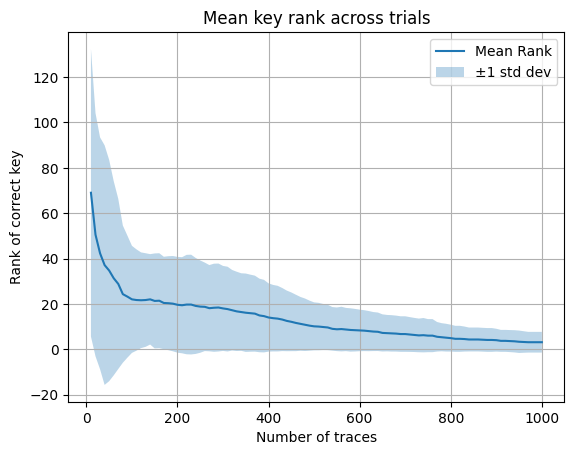

In [ ]:
predictions_vgg_se_best = best_model_vgg_se.predict(X_val)

steps, ranks = run_rank_trials(predictions_vgg_se_best, np.array(Profiling_meta)[val_idx], n_traces_per_trial=1000, n_trials=10)
plot_mean_rank(steps, ranks)

### Batch normalization ablation

In [ ]:
def vgg_se_builder_bn(hp):
  """! Hypermodel function - model builder for tuner
  """
  base_filters = hp.Choice("filter_scale", [1.0, 1.5, 2.0])
  filters = [int(f * base_filters) for f in [64, 128, 256, 512, 512]]
  dropout = hp.Float('dropout', 0.0, 0.6, step=0.3)
  se_ratio = hp.Choice('se_ratio', [8, 16, 32])

  learning_rate = hp.Choice("learning_rate", [1e-5, 5e-5, 1e-4, 5e-4])
  optimizer = RMSprop(learning_rate=learning_rate)
  model = cnn_squeeze_excite(filters=filters, dropout_rate=dropout, se_ratio=se_ratio, optimizer=optimizer, batch_normalize=True)
  model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

  return model

In [ ]:
tuner_bn = CleanMemoryTuner(
    hypermodel=vgg_se_builder_bn,
    objective="val_loss",
    max_trials=15,
    executions_per_trial=1,
    directory="/content/drive/MyDrive/attention_cnn_tuner_bn",
    project_name="vgg_se_ascad"
)

Reloading Tuner from /content/drive/MyDrive/attention_cnn_tuner_bn/vgg_se_ascad/tuner0.json


In [ ]:
# With batch norm

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Setup callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/vgg_se_trial_bn.keras", save_best_only=True)

# Run hyperparameter random search
tuner_bn.search(ds_train, validation_data=ds_val, callbacks=[early_stop, checkpoint], epochs=75, batch_size=64)

Trial 15 Complete [00h 26m 51s]
val_loss: 5.544605731964111

Best val_loss So Far: 5.544310092926025
Total elapsed time: 1d 05h 22m 21s


In [ ]:
# Save best model - with batch norm

best_model_vgg_se = tuner_bn.get_best_models(1)[0]
best_model_vgg_se.save("/content/drive/MyDrive/attention_cnn_tuner/vgg_se_best_bn.keras")
# best_model_vgg_se.save_weights("/content/drive/MyDrive/vgg_se_best_weights.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 36 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# With batch norm

import json
# Save best hyperparameters in a json file

best_hps = tuner_bn.get_best_hyperparameters(1)[0]
with open("/content/drive/MyDrive/vgg_se_best_hps_bn.json", "w") as f:
    json.dump(best_hps.values, f)

### Key rank on a validation set

In [ ]:
from tqdm import tqdm

def rank(predictions, metadata, real_key, traces_idxs, last_key_bytes_proba, target_byte, simulated_key):
	# Compute the rank
	if len(last_key_bytes_proba) == 0:
		# If this is the first rank we compute, initialize all the estimates to zero
		key_bytes_proba = np.zeros(256)
	else:
		# This is not the first rank we compute: we optimize things by using the
		# previous computations to save time!
		key_bytes_proba = last_key_bytes_proba

	for t_idx in traces_idxs:
		# Go back from the class to the key byte. '2' is the index of the byte (third byte) of interest.
		plaintext = metadata[t_idx]['plaintext'][target_byte]
		key = metadata[t_idx]['key'][target_byte]
		for key_guess in range(0, 256):
			# Our candidate key byte probability is the sum of the predictions logs
			if (simulated_key!=1):
				proba = predictions[t_idx][SBOX[plaintext ^ key_guess]]
			else:
				proba = predictions[t_idx][SBOX[plaintext ^ key ^ key_guess]]
			if proba != 0:
				key_bytes_proba[key_guess] += np.log(proba)
			else:
				# We do not want an -inf here, put a very small epsilon
				# that correspondis to a power of our min non zero proba
				min_proba_predictions = predictions[t_idx][np.array(predictions[t_idx]) != 0]
				if len(min_proba_predictions) == 0:
					print("Error: got a prediction with only zeroes ... this should not happen!")
					sys.exit(-1)
				min_proba = min(min_proba_predictions)
				key_bytes_proba[key_guess] += np.log(min_proba**2)
	# Now we find where our real key candidate lies in the estimation.
	# We do this by sorting our estimates and find the rank in the sorted array.
	sorted_proba = np.array(list(map(lambda a : key_bytes_proba[a], key_bytes_proba.argsort()[::-1])))
	real_key_rank = np.where(sorted_proba == key_bytes_proba[real_key])[0][0]
	return (real_key_rank, key_bytes_proba)

def run_rank_trials(predictions, metadata, n_traces_per_trial=1000, n_trials=10, rank_step=10, target_byte=2, simulated_key=0):
    real_key = metadata[0]['key'][target_byte] if not simulated_key else 0

    max_trace_idx = predictions.shape[0]
    steps = list(range(rank_step, n_traces_per_trial + 1, rank_step))

    all_ranks = []

    for trial in tqdm(range(n_trials), desc="Trials"):
        trace_indices = np.random.choice(np.arange(max_trace_idx), size=n_traces_per_trial, replace=False)
        trial_ranks = []
        key_bytes_proba = []

        for i in tqdm(steps, leave=False, desc=f"Rank steps (Trial {trial+1})"):
            selected = trace_indices[:i]
            rank_val, key_bytes_proba = rank(predictions, metadata, real_key, selected, key_bytes_proba, target_byte, simulated_key)
            trial_ranks.append(rank_val)

        all_ranks.append(trial_ranks)

    return steps, np.array(all_ranks)

def plot_mean_rank(steps, ranks_matrix):
    import matplotlib.pyplot as plt
    mean_ranks = np.mean(ranks_matrix, axis=0)
    std_ranks = np.std(ranks_matrix, axis=0)

    plt.plot(steps, mean_ranks, label='Mean Rank')
    plt.fill_between(steps, mean_ranks - std_ranks, mean_ranks + std_ranks, alpha=0.3, label='±1 std dev')
    plt.xlabel("Number of traces")
    plt.ylabel("Rank of correct key")
    plt.title("Mean key rank across trials")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
SBOX =  np.array(
        [0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67,
        0x2b, 0xfe, 0xd7, 0xab, 0x76, 0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59,
        0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0, 0xb7,
        0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1,
        0x71, 0xd8, 0x31, 0x15, 0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05,
        0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75, 0x09, 0x83,
        0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29,
        0xe3, 0x2f, 0x84, 0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
        0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf, 0xd0, 0xef, 0xaa,
        0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c,
        0x9f, 0xa8, 0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc,
        0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2, 0xcd, 0x0c, 0x13, 0xec,
        0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19,
        0x73, 0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee,
        0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb, 0xe0, 0x32, 0x3a, 0x0a, 0x49,
        0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
        0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4,
        0xea, 0x65, 0x7a, 0xae, 0x08, 0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6,
        0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a, 0x70,
        0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9,
        0x86, 0xc1, 0x1d, 0x9e, 0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e,
        0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf, 0x8c, 0xa1,
        0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0,
        0x54, 0xbb, 0x16])

In [ ]:
no_bn_best_se_path = "/content/drive/MyDrive/attention_cnn_tuner/vgg_se_best.keras"
bn_best_se_path = "/content/drive/MyDrive/attention_cnn_tuner/vgg_se_best_bn.keras"

# best_se = tf.keras.models.load_model(no_bn_best_se_path)
best_se_bn = tf.keras.models.load_model(bn_best_se_path)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 36 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


Trials: 100%|██████████| 10/10 [04:16<00:00, 25.64s/it]


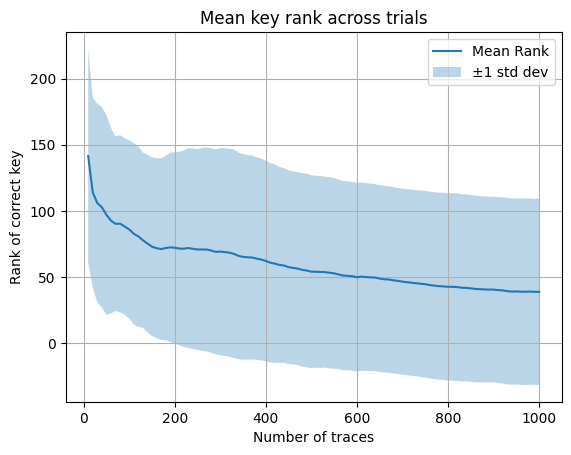

In [ ]:
predictions = best_se_bn.predict(X_val)
# probas = tf.nn.softmax(predictions, axis=1).numpy()

steps, ranks = run_rank_trials(predictions, np.array(Profiling_meta)[val_idx], n_traces_per_trial=1000, n_trials=10)
plot_mean_rank(steps, ranks)

Key rank on a validation set does drop.

### Hypertuning lite
* Lower the number of Dense layers
* LR log search

In [ ]:
# VGG_SE - best
# {'filter_scale': 2.0, 'dropout': 0.1, 'se_ratio': 16, 'learning_rate': 5e-05}

filter_scale_se_best = 2.0
filters_se_best = [int(f * filter_scale_se_best) for f in [64, 128, 256, 512, 512]]

dropout_se_best = 0.1
se_ratio_best = 16

In [ ]:
def cnn_squeeze_excite_lite(filters, se_ratio, dropout_rate, dense_size, classes=256,input_dim=700, batch_normalize=False):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(filters[0], 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	if batch_normalize:
		x = BatchNormalization()(x)
	# Block 2
	x = Conv1D(filters[1], 11, activation='relu', padding='same', name='block2_conv1')(x)
	if batch_normalize:
		x = BatchNormalization()(x)
	# Squeeze excitation block 1
	x = se_block(x, ratio=se_ratio)
	x = MaxPooling1D(2)(x)

	# Block 3
	x = Conv1D(filters[2], 11, activation='relu', padding='same', name='block3_conv1')(x)
	if batch_normalize:
		x = BatchNormalization()(x)
	# Block 4
	x = Conv1D(filters[3], 11, activation='relu', padding='same', name='block4_conv1')(x)
	if batch_normalize:
		x = BatchNormalization()(x)
  # Block 5
	x = Conv1D(filters[4], 11, activation='relu', padding='same', name='block5_conv1')(x)
	if batch_normalize:
		x = BatchNormalization()(x)
 	# Squeeze excitation block 1
	x = se_block(x, ratio=se_ratio)
	x = MaxPooling1D(2)(x)

	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(dense_size, activation='relu', name='fc1')(x)
	x = Dropout(dropout_rate)(x)
	x = Dense(dense_size, activation='relu', name='fc2')(x)
	x = Dropout(dropout_rate)(x)
	x = Dense(classes, activation='softmax', name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_squeeze_excitation_lite')
	return model

In [ ]:
def vgg_se_builder_lite_vgg_se(hp):
  """! Hypermodel function - model builder for tuner
  """
  # Fixed params
  filters = filters_se_best
  dropout = dropout_se_best
  se_ratio = se_ratio_best

  # Variable dense sizes - smaller layers
  dense_size = hp.Choice("dense_size", [2048, 1024, 512, 256])

  # Variable learning rate - wider range
  learning_rate = hp.Float("learning_rate", min_value=1e-6, max_value=1e-2, sampling="log")
  optimizer = RMSprop(learning_rate=learning_rate)

  model = cnn_squeeze_excite_lite(filters=filters,        # Fixed
                                  dropout_rate=dropout,   # Fixed
                                  dense_size=dense_size,  # Variable
                                  se_ratio=se_ratio,      # Fixed
                                  batch_normalize=True)   # Fixed

  model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

  return model

In [ ]:
tuner_lite = CleanMemoryTuner(
    hypermodel=vgg_se_builder_lite_vgg_se,
    objective="val_loss",
    max_trials=15,
    executions_per_trial=1,
    directory="/content/drive/MyDrive/attention_cnn_tuner_lite_vgg_se",
    project_name="vgg_se_ascad_lite"
)

Reloading Tuner from /content/drive/MyDrive/attention_cnn_tuner_lite_vgg_se/vgg_se_ascad_lite/tuner0.json


In [ ]:
tuner_lite.results_summary()

Results summary
Results in /content/drive/MyDrive/attention_cnn_tuner_lite_vgg_se/vgg_se_ascad_lite
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 13 summary
Hyperparameters:
dense_size: 2048
learning_rate: 0.000392143905191291
Score: 5.513279914855957

Trial 10 summary
Hyperparameters:
dense_size: 1024
learning_rate: 9.057241938432416e-06
Score: 5.544428825378418

Trial 00 summary
Hyperparameters:
dense_size: 1024
learning_rate: 0.00010460572344955694
Score: 5.544604301452637

Trial 14 summary
Hyperparameters:
dense_size: 256
learning_rate: 0.0002227511976382995
Score: 5.544612407684326

Trial 01 summary
Hyperparameters:
dense_size: 256
learning_rate: 0.00048439418459670996
Score: 5.544618129730225

Trial 08 summary
Hyperparameters:
dense_size: 256
learning_rate: 7.4536725724834605e-06
Score: 5.544638156890869

Trial 09 summary
Hyperparameters:
dense_size: 512
learning_rate: 1.0139231824314296e-05
Score: 5.5446600914001465

Trial 11 summary
Hyperparameters:


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Setup callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/vgg_se_trial_lite.keras", save_best_only=True)

# Run hyperparameter random search
tuner_lite.search(ds_train, validation_data=ds_val, callbacks=[early_stop, checkpoint], epochs=75, batch_size=128)

Trial 15 Complete [00h 16m 35s]
val_loss: 5.544612407684326

Best val_loss So Far: 5.513279914855957
Total elapsed time: 13h 28m 29s


#### Validate key rank

In [ ]:
vgg_se_rank_validation_model = tuner_lite.get_best_models(1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 36 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
predictions = vgg_se_rank_validation_model.predict(ds_val)

79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step


Trials: 100%|██████████| 10/10 [04:15<00:00, 25.56s/it]


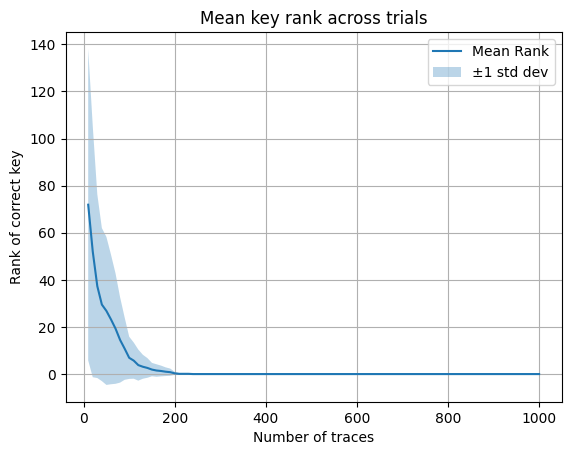

In [ ]:
steps, ranks = run_rank_trials(predictions, meta_val, n_traces_per_trial=1000, n_trials=10)
plot_mean_rank(steps, ranks)

## Full training

Train the best model on the whole profiling dataset

In [ ]:
import json
from tensorflow.keras.models import load_model

with open("/content/drive/MyDrive/vgg_se_best_hps.json", "r") as f:
  hp_vals = json.load(f)

dropout_best = hp_vals['dropout']
se_ratio_best = hp_vals['se_ratio']
filter_scale_best = hp_vals['filter_scale']

learning_rate_best = hp_vals['learning_rate']

In [ ]:
filters = [int(f * filter_scale_best) for f in [64, 128, 256, 512, 512]]
final_vgg_se_model = cnn_squeeze_excite(se_ratio=se_ratio_best, dropout_rate=dropout_best, filters=filters)

In [ ]:
final_vgg_se_model.summary()

Model: "cnn_squeeze_excitation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 700, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 700, 128)  │      1,536 │ input_layer_1[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 700, 256)  │    360,704 │ block1_conv1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ block2_conv1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      4,112 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │      4,352 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 700, 256)  │          0 │ block2_conv1[0][… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 350, 256)  │          0 │ multiply[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 350, 512)  │  1,442,304 │ max_pooling1d[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 350, 1024) │  5,768,192 │ block3_conv1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 350, 1024) │ 11,535,360 │ block4_conv1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ block5_conv1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     65,600 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1024)      │     66,560 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1024)   │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 350, 1024) │          0 │ block5_conv1[0][… │
│ (Multiply)          │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 175, 1024) │          0 │ multiply_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 179200)    │          0 │ max_pooling1d_1[

 Total params: 771,086,160 (2.87 GB)

 Trainable params: 771,086,160 (2.87 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_full = ModelCheckpoint("/content/drive/MyDrive/vgg_se_fully_trained_chckpnt.keras", monitor='accuracy', save_best_only=True)

final_vgg_se_model.fit(ds_train, epochs=75, batch_size=64, callbacks=[checkpoint_full])

final_vgg_se_model.save("/content/drive/MyDrive/vgg_se_best_fully_trained.keras")

Epoch 1/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 238s 263ms/step - accuracy: 0.0039 - loss: 5.5517
Epoch 2/75


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 195s 249ms/step - accuracy: 0.0039 - loss: 5.5448
Epoch 3/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 194s 249ms/step - accuracy: 0.0042 - loss: 5.5443
Epoch 4/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 194s 248ms/step - accuracy: 0.0051 - loss: 5.5437
Epoch 5/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 195s 249ms/step - accuracy: 0.0051 - loss: 5.5440
Epoch 6/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 195s 249ms/step - accuracy: 0.0053 - loss: 5.5435
Epoch 7/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 194s 249ms/step - accuracy: 0.0042 - loss: 5.5430
Epoch 8/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 195s 249ms/step - accuracy: 0.0053 - loss: 5.5428
Epoch 9/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 195s 249ms/step - accuracy: 0.0055 - loss: 5.5429
Epoch 10/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 195s 249ms/step - accuracy: 0.0047 - loss: 5.5430
Epoch 11/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 195s 249ms/step - accuracy: 0.0049 - loss: 5.5432
Epoch 12/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 195s 249ms/step - accuracy: 0.0048 - loss: 5.5428
Epoch 13/75
782/78

### Batch normalization ablation

In [ ]:
# With BN

import json
from tensorflow.keras.models import load_model

with open("/content/drive/MyDrive/vgg_se_best_hps_bn.json", "r") as f:
  hp_vals = json.load(f)

dropout_best = hp_vals['dropout']
se_ratio_best = hp_vals['se_ratio']
filter_scale_best = hp_vals['filter_scale']

learning_rate_best = hp_vals['learning_rate']

In [ ]:
# With BN

filters_bn = [int(f * filter_scale_best) for f in [64, 128, 256, 512, 512]]
optimizer = RMSprop(learning_rate=learning_rate_best)
final_vgg_se_model_bn = cnn_squeeze_excite(se_ratio=se_ratio_best, dropout_rate=dropout_best, filters=filters_bn, optimizer=optimizer)

In [ ]:
final_vgg_se_model_bn.summary()

Model: "cnn_squeeze_excitation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 700, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 700, 64)   │        768 │ input_layer_1[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 700, 128)  │     90,240 │ block1_conv1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ block2_conv1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 8)         │      1,032 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │      1,152 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 128)    │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 700, 128)  │          0 │ block2_conv1[0][… │
│ (Multiply)          │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 350, 128)  │          0 │ multiply_2[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 350, 256)  │    360,704 │ max_pooling1d_2[… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 350, 512)  │  1,442,304 │ block3_conv1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 350, 512)  │  2,884,096 │ block4_conv1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ block5_conv1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │     16,416 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │     16,896 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 512)    │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 350, 512)  │          0 │ block5_conv1[0][… │
│ (Multiply)          │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 175, 512)  │          0 │ multiply_3[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 89600)     │          0 │ max_pooling1d_3[

 Total params: 389,649,448 (1.45 GB)

 Trainable params: 389,649,448 (1.45 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_full = ModelCheckpoint("/content/drive/MyDrive/vgg_se_fully_trained_chckpnt_bn.keras", monitor='accuracy', save_best_only=True)

final_vgg_se_model_bn.fit(ds_train, epochs=75, batch_size=64, callbacks=[checkpoint_full])

final_vgg_se_model_bn.save("/content/drive/MyDrive/vgg_se_best_fully_trained_bn.keras")

Epoch 1/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 104s 134ms/step - accuracy: 0.0043 - loss: 5.5523
Epoch 2/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 91s 129ms/step - accuracy: 0.0044 - loss: 5.5445
Epoch 3/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 143s 203ms/step - accuracy: 0.0048 - loss: 5.5440
Epoch 4/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 72s 102ms/step - accuracy: 0.0045 - loss: 5.5438
Epoch 5/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 72s 102ms/step - accuracy: 0.0053 - loss: 5.5437
Epoch 6/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 72s 102ms/step - accuracy: 0.0052 - loss: 5.5432
Epoch 7/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 72s 102ms/step - accuracy: 0.0045 - loss: 5.5431
Epoch 8/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 89s 126ms/step - accuracy: 0.0054 - loss: 5.5423
Epoch 9/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 72s 101ms/step - accuracy: 0.0045 - loss: 5.5427
Epoch 10/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 71s 101ms/step - accuracy: 0.0039 - loss: 5.5429
Epoch 11/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 71s 101ms/step - accuracy: 0.0046 - loss: 5.5415
Epoch 12/75
704/7

Conclusion - BatchNormalization greatly influences the training stability. Best model with SE & BN outperforms the non-BN variant by an order on magnitude when trained on full profiling set.

# CBAM block

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, Lambda
from tensorflow.keras.layers import Dense, Reshape, Multiply, Add, Conv1D, Activation, Concatenate

def cbam_block(input_tensor, ratio=16, name_prefix="cbam"):
  channel = input_tensor.shape[-1]

  avg_pool = GlobalAveragePooling1D()(input_tensor)
  max_pool = GlobalMaxPooling1D()(input_tensor)

  shared_dense_1 = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
  shared_dense_2 = Dense(channel, kernel_initializer='he_normal', use_bias=True)

  mlp_avg = shared_dense_2(shared_dense_1(avg_pool))
  mlp_max = shared_dense_2(shared_dense_1(max_pool))

  channel_attention = Activation('sigmoid')(Add()([mlp_avg, mlp_max]))
  channel_attention = Reshape((1, channel))(channel_attention)

  x = Multiply()([input_tensor, channel_attention])

  # avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
  # max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
  avg_pool = Lambda(lambda z: K.mean(z, axis=-1, keepdims=True))(x)
  max_pool = Lambda(lambda z: K.max(z, axis=-1, keepdims=True))(x)
  concat = Concatenate(axis=-1)([avg_pool, max_pool])

  spatial_attention = Conv1D(filters=1, kernel_size=7, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)

  cbam_out = Multiply()([x, spatial_attention])
  return cbam_out

In [ ]:
def vgg_cnn_cbam(filters, cbam_ratio, dropout_rate, optimizer, classes=256,input_dim=700, batch_normalize=False):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(filters[0], 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	if batch_normalize:
		x = BatchNormalization()(x)
	x = AveragePooling1D(2, strides=2, name='block1_pool1')(x)
	# Block 2
	x = Conv1D(filters[1], 11, activation='relu', padding='same', name='block2_conv1')(x)
	if batch_normalize:
		x = BatchNormalization()(x)
	# Squeeze excitation block 1
	x = cbam_block(x, ratio=cbam_ratio)
	x = AveragePooling1D(2, strides=2, name='block1_pool2')(x)

	# Block 3
	x = Conv1D(filters[2], 11, activation='relu', padding='same', name='block3_conv1')(x)
	if batch_normalize:
		x = BatchNormalization()(x)
	x = AveragePooling1D(2, strides=2, name='block1_pool3')(x)
	# Block 4
	x = Conv1D(filters[3], 11, activation='relu', padding='same', name='block4_conv1')(x)
	if batch_normalize:
		x = BatchNormalization()(x)
	x = AveragePooling1D(2, strides=2, name='block1_pool4')(x)
  # Block 5
	x = Conv1D(filters[4], 11, activation='relu', padding='same', name='block5_conv1')(x)
	if batch_normalize:
		x = BatchNormalization()(x)
 	# Squeeze excitation block 1
	x = cbam_block(x, ratio=cbam_ratio)
	x = AveragePooling1D(2, strides=2, name='block1_pool5')(x)

	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dropout(dropout_rate)(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	x = Dropout(dropout_rate)(x)
	x = Dense(classes, activation='softmax', name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_squeeze_excitation')

	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model

## CBAM_VGG Hyperparameter tuning

In [ ]:
def vgg_cbam_builder(hp):
  """! Hypermodel function - model builder for tuner
  """
  base_filters = hp.Choice("filter_scale", [1.0, 1.5, 2.0])
  filters = [int(f * base_filters) for f in [64, 128, 256, 512, 512]]
  dropout = hp.Float('dropout', 0.0, 0.6, step=0.3)
  cbam_ratio = hp.Choice('cbam_ratio', [8, 16, 32])

  learning_rate = hp.Choice("learning_rate", [1e-5, 5e-5, 1e-4, 5e-4])
  optimizer = RMSprop(learning_rate=learning_rate)
  model = vgg_cnn_cbam(filters=filters, dropout_rate=dropout, cbam_ratio=cbam_ratio, optimizer=optimizer)
  model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

  return model

In [ ]:
tuner_cbam = CleanMemoryTuner(
    hypermodel=vgg_cbam_builder,
    objective="val_loss",
    max_trials=15,
    executions_per_trial=1,
    directory="/content/drive/MyDrive/attention_cnn_tuner",
    project_name="vgg_cbam_ascad"
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Setup callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/vgg_cbam_trial.keras", save_best_only=True)

# Run hyperparameter random search
tuner_cbam.search(ds_train, validation_data=ds_val, callbacks=[early_stop, checkpoint], epochs=75, batch_size=64)

Trial 15 Complete [00h 03m 23s]
val_loss: 5.544747829437256

Best val_loss So Far: 5.544383525848389
Total elapsed time: 01h 15m 22s


In [ ]:
# Save best model

best_model_vgg_cbam = tuner_cbam.get_best_models(1)[0]
best_model_vgg_cbam.save("/content/drive/MyDrive/attention_cnn_tuner/vgg_cbam_best.keras")
# best_model_vgg_cbam.save_weights("/content/drive/MyDrive/vgg_cbam_best_weights.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def vgg_cbam_builder_bn(hp):
  """! Hypermodel function - model builder for tuner
  """
  base_filters = hp.Choice("filter_scale", [1.0, 1.5, 2.0])
  filters = [int(f * base_filters) for f in [64, 128, 256, 512, 512]]
  dropout = hp.Float('dropout', 0.0, 0.6, step=0.3)
  cbam_ratio = hp.Choice('cbam_ratio', [8, 16, 32])

  learning_rate = hp.Choice("learning_rate", [1e-5, 5e-5, 1e-4, 5e-4])
  optimizer = RMSprop(learning_rate=learning_rate)
  model = vgg_cnn_cbam(filters=filters, dropout_rate=dropout, cbam_ratio=cbam_ratio, optimizer=optimizer, batch_normalize=True)
  model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

  return model

In [ ]:
tuner_cbam_bn = CleanMemoryTuner(
    hypermodel=vgg_cbam_builder_bn,
    objective="val_loss",
    max_trials=15,
    executions_per_trial=1,
    directory="/content/drive/MyDrive/attention_cnn_tuner_bn",
    project_name="vgg_cbam_ascad_bn"
)

Reloading Tuner from /content/drive/MyDrive/attention_cnn_tuner_bn/vgg_cbam_ascad_bn/tuner0.json


In [ ]:
import json
# Save best hyperparameters in a json file

best_hps = tuner_cbam_bn.get_best_hyperparameters(1)[0]
with open("/content/drive/MyDrive/vgg_cbam_best_hps.json", "w") as f:
    json.dump(best_hps.values, f)

In [ ]:
best_model_vgg_cbam.summary()

Model: "cnn_squeeze_excitation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 700, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 700, 96)   │      1,152 │ input_layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool1        │ (None, 350, 96)   │          0 │ block1_conv1[0][… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 350, 192)  │    202,944 │ block1_pool1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ block2_conv1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 192)       │          0 │ block2_conv1[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 6)         │      1,158 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 192)       │      1,344 │ dense[0][0],      │
│                     │                   │            │ dense[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 192)       │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 192)       │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 192)    │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 350, 192)  │          0 │ block2_conv1[0][… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 350, 1)    │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 350, 1)    │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 350, 2)    │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 350, 1)    │         14 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 350, 192)  │          0 │ multiply[0][0],   │
│ (Multiply)          │                   │            │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool2        │ (None, 175, 192)  │          0 │ multiply_1[0][0]  │
│ (AveragePooling1D)  │                   │            │                 

 Total params: 94,683,834 (361.19 MB)

 Trainable params: 94,683,834 (361.19 MB)

 Non-trainable params: 0 (0.00 B)

### Batch normalization ablation

In [ ]:
# Batch norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Setup callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/vgg_cbam_trial_bn.keras", save_best_only=True)

# Run hyperparameter random search
tuner_cbam_bn.search(ds_train, validation_data=ds_val, callbacks=[early_stop, checkpoint], epochs=75, batch_size=64)

Trial 15 Complete [00h 00m 17s]

Best val_loss So Far: 5.5015716552734375
Total elapsed time: 01h 21m 31s


In [ ]:
# Save best model BN

best_model_vgg_cbam_bn = tuner_cbam_bn.get_best_models(1)[0]
best_model_vgg_cbam_bn.save("/content/drive/MyDrive/attention_cnn_tuner/vgg_cbam_best_bn.keras")
# best_model_vgg_cbam.save_weights("/content/drive/MyDrive/vgg_cbam_best_weights.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# BatchNorm
import json
# Save best hyperparameters in a json file

best_hps = tuner_cbam_bn.get_best_hyperparameters(1)[0]
with open("/content/drive/MyDrive/vgg_cbam_best_hps_bn.json", "w") as f:
    json.dump(best_hps.values, f)

In [ ]:
best_model_vgg_cbam_bn.summary()

Model: "cnn_squeeze_excitation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 700, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 700, 96)   │      1,152 │ input_layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 700, 96)   │        384 │ block1_conv1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool1        │ (None, 350, 96)   │          0 │ batch_normalizat… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 350, 192)  │    202,944 │ block1_pool1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 350, 192)  │        768 │ block2_conv1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 192)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 24)        │      4,632 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 192)       │      4,800 │ dense[0][0],      │
│                     │                   │            │ dense[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 192)       │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 192)       │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 192)    │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 350, 192)  │          0 │ batch_normalizat… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 350, 1)    │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 350, 1)    │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 350, 2)    │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 350, 1)    │         14 │ concatenate[0][0

 Total params: 94,810,260 (361.67 MB)

 Trainable params: 94,805,844 (361.66 MB)

 Non-trainable params: 4,416 (17.25 KB)

### Hypertuning lite

In [ ]:
def vgg_cnn_cbam_lite(filters, cbam_ratio, dropout_rate, dense_size, classes=256,input_dim=700, batch_normalize=False):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(filters[0], 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	if batch_normalize:
		x = BatchNormalization()(x)
	x = AveragePooling1D(2, strides=2, name='block1_pool1')(x)
	# Block 2
	x = Conv1D(filters[1], 11, activation='relu', padding='same', name='block2_conv1')(x)
	if batch_normalize:
		x = BatchNormalization()(x)
	# Squeeze excitation block 1
	x = cbam_block(x, ratio=cbam_ratio)
	x = AveragePooling1D(2, strides=2, name='block1_pool2')(x)

	# Block 3
	x = Conv1D(filters[2], 11, activation='relu', padding='same', name='block3_conv1')(x)
	if batch_normalize:
		x = BatchNormalization()(x)
	x = AveragePooling1D(2, strides=2, name='block1_pool3')(x)
	# Block 4
	x = Conv1D(filters[3], 11, activation='relu', padding='same', name='block4_conv1')(x)
	if batch_normalize:
		x = BatchNormalization()(x)
	x = AveragePooling1D(2, strides=2, name='block1_pool4')(x)
  # Block 5
	x = Conv1D(filters[4], 11, activation='relu', padding='same', name='block5_conv1')(x)
	if batch_normalize:
		x = BatchNormalization()(x)
 	# Squeeze excitation block 1
	x = cbam_block(x, ratio=cbam_ratio)
	x = AveragePooling1D(2, strides=2, name='block1_pool5')(x)

	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(dense_size, activation='relu', name='fc1')(x)
	x = Dropout(dropout_rate)(x)
	x = Dense(dense_size, activation='relu', name='fc2')(x)
	x = Dropout(dropout_rate)(x)
	x = Dense(classes, activation='softmax', name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_squeeze_excitation')

	return model

In [ ]:
# Load best hyperparams from the previous tuner searches
with open("/content/drive/MyDrive/vgg_cbam_best_hps_bn.json", "r") as f:
    hp_vals_cbam = json.load(f)

best_filter_scale_cbam = hp_vals_cbam['filter_scale']
best_dropout_cbam = hp_vals_cbam['dropout']
best_cbam_ratio = hp_vals_cbam['cbam_ratio']

In [ ]:
best_cbam_ratio

8

In [ ]:
def vgg_cbam_builder_lite(hp):
  """! Hypermodel function - model builder for tuner
  """
  filter_scale = best_filter_scale_cbam # Fixed
  filters = [int(f * filter_scale) for f in [64, 128, 256, 512, 512]] # Fixed
  dropout = best_dropout_cbam # Fixed
  cbam_ratio = best_cbam_ratio # Fixed
  batch_norm = True # Fixed

  # Variable dense sizes - smaller layers
  dense_size = hp.Choice("dense_size", [2048, 1024, 512, 256])

  # Variable
  learning_rate = hp.Float("learning_rate", min_value=1e-6 , max_value=1e-3, sampling="log")
  optimizer = RMSprop(learning_rate=learning_rate)

  model = vgg_cnn_cbam_lite(filters=filters, dense_size=dense_size, dropout_rate=dropout, cbam_ratio=cbam_ratio, batch_normalize=batch_norm)
  model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

  return model

In [ ]:
tuner_lite_cbam = CleanMemoryTuner(
    hypermodel=vgg_cbam_builder_lite,
    objective="val_loss",
    max_trials=15,
    executions_per_trial=1,
    directory="/content/drive/MyDrive/attention_cnn_tuner_lite_vgg_cbam",
    project_name="vgg_cbam_ascad_lite"
)

Reloading Tuner from /content/drive/MyDrive/attention_cnn_tuner_lite_vgg_cbam/vgg_cbam_ascad_lite/tuner0.json


{'dense_size': 2048, 'learning_rate': 0.0006013568341243019}

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Setup callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/vgg_cbam_trial_lite.keras", save_best_only=True)

# Run hyperparameter random search
tuner_lite_cbam.search(ds_train, validation_data=ds_val, callbacks=[early_stop, checkpoint], epochs=75, batch_size=128)

Trial 15 Complete [00h 02m 47s]
val_loss: 5.544613361358643

Best val_loss So Far: 5.54442024230957
Total elapsed time: 02h 17m 12s


#### Validate key rank

In [ ]:
vgg_cbam_lite_rank_validation_model = tuner_lite_cbam.get_best_models(1)[0]

predictions = vgg_cbam_lite_rank_validation_model.predict(ds_val)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step


Trials: 100%|██████████| 10/10 [04:15<00:00, 25.53s/it]


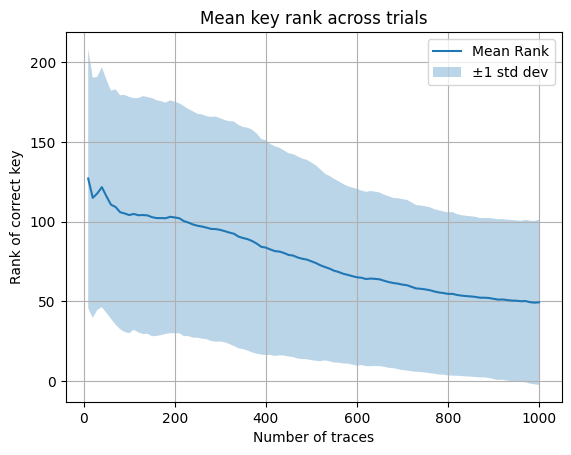

In [ ]:
steps, ranks = run_rank_trials(predictions, meta_val, n_traces_per_trial=1000, n_trials=10)
plot_mean_rank(steps, ranks)

## Full training

In [ ]:
checkpoint_full = ModelCheckpoint("/content/drive/MyDrive/vgg_cbam_fully_trained_chckpnt.keras", monitor='accuracy', save_best_only=True)

best_model_vgg_cbam.fit(ds_train, epochs=75, batch_size=64, callbacks=[checkpoint_full])

best_model_vgg_cbam.save("/content/drive/MyDrive/vgg_cban_best_fully_trained.keras")

Epoch 1/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 46ms/step - accuracy: 0.0046 - loss: 5.5448
Epoch 2/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.0040 - loss: 5.5439
Epoch 3/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.0049 - loss: 5.5434
Epoch 4/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.0050 - loss: 5.5429
Epoch 5/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.0055 - loss: 5.5429
Epoch 6/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.0049 - loss: 5.5429
Epoch 7/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.0044 - loss: 5.5427
Epoch 8/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.0046 - loss: 5.5429
Epoch 9/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.0045 - loss: 5.5428
Epoch 10/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.0050 - loss: 5.5429
Epoch 11/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.0044 - loss: 5.5425
Epoch 12/75
782/782 ━━━━━━━━━━

### Batch normalization ablation

In [ ]:
checkpoint_full = ModelCheckpoint("/content/drive/MyDrive/vgg_cbam_fully_trained_chckpnt_bn.keras", monitor='accuracy', save_best_only=True)

best_model_vgg_cbam_bn.fit(ds_train, epochs=75, batch_size=64, callbacks=[checkpoint_full])

best_model_vgg_cbam_bn.save("/content/drive/MyDrive/vgg_cban_best_fully_trained_bn.keras")

Epoch 1/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 48ms/step - accuracy: 0.0074 - loss: 5.4837
Epoch 2/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.0071 - loss: 5.4807
Epoch 3/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.0072 - loss: 5.4853
Epoch 4/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.0085 - loss: 5.4771
Epoch 5/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.0071 - loss: 5.4814
Epoch 6/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.0071 - loss: 5.4765
Epoch 7/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.0074 - loss: 5.4762
Epoch 8/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.0085 - loss: 5.4718
Epoch 9/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.0085 - loss: 5.4712
Epoch 10/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.0094 - loss: 5.4654
Epoch 11/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.0087 - loss: 5.4578
Epoch 12/75
782/782 ━━━━━━━━━━

### Lite model + lr refinement

In [ ]:
best_hps_cbam_lite = tuner_lite_cbam.get_best_hyperparameters(1)[0]

vgg_cbam_lite = tuner_lite_cbam.hypermodel.build(best_hps_cbam_lite)

In [ ]:
checkpoint_full = ModelCheckpoint("/content/drive/MyDrive/vgg_cbam_fully_trained_chckpnt_lite.keras", monitor='accuracy', save_best_only=True)

vgg_cbam_lite.fit(ds_train_full, epochs=75, batch_size=64, callbacks=[checkpoint_full])

vgg_cbam_lite.save("/content/drive/MyDrive/vgg_cbam_best_fully_trained_lite.keras")

Epoch 1/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 41ms/step - accuracy: 0.0042 - loss: 5.5460
Epoch 2/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.0047 - loss: 5.5447
Epoch 3/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.0049 - loss: 5.5441
Epoch 4/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.0051 - loss: 5.5432
Epoch 5/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.0046 - loss: 5.5431
Epoch 6/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.0043 - loss: 5.5430
Epoch 7/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.0050 - loss: 5.5430
Epoch 8/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.0046 - loss: 5.5430
Epoch 9/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.0049 - loss: 5.5423
Epoch 10/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.0051 - loss: 5.5424
Epoch 11/75
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.0049 - loss: 5.5424
Epoch 12/75
782/782 ━━━━━━━━━━

ASCAD:

> Roughly speaking, this suggest that, for SCA attacks, the QDA part of CNN networks is simulated by dense layers, while convolutional layers essentially extract information (e.g. by combining leakage points and/or by dealing with the desynchronization). The results also confirm that the number of dense layers increases the SCA-efficiency. Hence fully connected layers are a critical part of the CNN network in the context of SCA, and shall be not removed.

# Hypermodel selection

For each of the architectures explored in the above sections, we list the hyper search results in this section.

In [ ]:
%load_ext tensorboard

# DO NOT RUN ATTACK UNTIL ALL OF THE MODELS HAVE BEEN TRAINED

# Final evaluation (Attack)

Evaluation on attack traces (test set). Now we run attack using the fully trained CNN + attention models. Calculating the ranks, and visualizing mean ranks.

### Rank evaluation utils

In [ ]:
from tqdm import tqdm

def rank(predictions, metadata, real_key, traces_idxs, last_key_bytes_proba, target_byte, simulated_key):
	# Compute the rank
	if len(last_key_bytes_proba) == 0:
		# If this is the first rank we compute, initialize all the estimates to zero
		key_bytes_proba = np.zeros(256)
	else:
		# This is not the first rank we compute: we optimize things by using the
		# previous computations to save time!
		key_bytes_proba = last_key_bytes_proba

	for t_idx in traces_idxs:
		# Go back from the class to the key byte. '2' is the index of the byte (third byte) of interest.
		plaintext = metadata[t_idx]['plaintext'][target_byte]
		key = metadata[t_idx]['key'][target_byte]
		for key_guess in range(0, 256):
			# Our candidate key byte probability is the sum of the predictions logs
			if (simulated_key!=1):
				proba = predictions[t_idx][SBOX[plaintext ^ key_guess]]
			else:
				proba = predictions[t_idx][SBOX[plaintext ^ key ^ key_guess]]
			if proba != 0:
				key_bytes_proba[key_guess] += np.log(proba)
			else:
				# We do not want an -inf here, put a very small epsilon
				# that correspondis to a power of our min non zero proba
				min_proba_predictions = predictions[t_idx][np.array(predictions[t_idx]) != 0]
				if len(min_proba_predictions) == 0:
					print("Error: got a prediction with only zeroes ... this should not happen!")
					sys.exit(-1)
				min_proba = min(min_proba_predictions)
				key_bytes_proba[key_guess] += np.log(min_proba**2)
	# Now we find where our real key candidate lies in the estimation.
	# We do this by sorting our estimates and find the rank in the sorted array.
	sorted_proba = np.array(list(map(lambda a : key_bytes_proba[a], key_bytes_proba.argsort()[::-1])))
	real_key_rank = np.where(sorted_proba == key_bytes_proba[real_key])[0][0]
	return (real_key_rank, key_bytes_proba)

def run_rank_trials(predictions, metadata, n_traces_per_trial=1000, n_trials=10, rank_step=10, target_byte=2, simulated_key=0):
    real_key = metadata[0]['key'][target_byte] if not simulated_key else 0

    max_trace_idx = predictions.shape[0]
    steps = list(range(rank_step, n_traces_per_trial + 1, rank_step))

    all_ranks = []

    for trial in tqdm(range(n_trials), desc="Trials"):
        trace_indices = np.random.choice(np.arange(max_trace_idx), size=n_traces_per_trial, replace=False)
        trial_ranks = []
        key_bytes_proba = []

        for i in tqdm(steps, leave=False, desc=f"Rank steps (Trial {trial+1})"):
            selected = trace_indices[:i]
            rank_val, key_bytes_proba = rank(predictions, metadata, real_key, selected, key_bytes_proba, target_byte, simulated_key)
            trial_ranks.append(rank_val)

        all_ranks.append(trial_ranks)

    return steps, np.array(all_ranks)

def plot_mean_rank(steps, ranks_matrix):
    import matplotlib.pyplot as plt
    mean_ranks = np.mean(ranks_matrix, axis=0)
    std_ranks = np.std(ranks_matrix, axis=0)

    plt.plot(steps, mean_ranks, label='Mean Rank')
    plt.fill_between(steps, mean_ranks - std_ranks, mean_ranks + std_ranks, alpha=0.3, label='±1 std dev')
    plt.xlabel("Number of traces")
    plt.ylabel("Rank of correct key")
    plt.title("Mean key rank across trials")
    plt.grid(True)
    plt.legend()
    plt.show()

---

### VGG_SE

In [ ]:
final_vgg_se_predictions = final_vgg_se_model.predict(X_attack)

In [ ]:
steps, ranks = run_rank_trials(final_vgg_se_predictions, atck_metadata, n_traces_per_trial=1000, n_trials=10)

In [ ]:
plot_mean_rank(steps, ranks)

### VGG_CBAM

In [ ]:
final_vgg_cbam_predictions = final_vgg_cbam_model.predict(X_attack)

In [ ]:
steps, ranks = run_rank_trials(final_vgg_cbam_predictions, atck_metadata, n_traces_per_trial=1000, n_trials=10)

In [ ]:
plot_mean_rank(steps, ranks)